In [1]:
from scipy.ndimage.measurements import label as bwlabel
from scipy.ndimage import measurements
from skimage.measure import regionprops
from pylab import *

import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
sns.set()
rcParams['figure.figsize'] = (12, 8)

sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context("poster")

In [3]:
def percolation_matrix(p, L):
    """Creates and returns a labeled percolation matrix, and the number of clusters."""
    prob_matrix = rand(L, L)
    perc_matrix = prob_matrix < p
    
    label_perc_matrix, n_clusters = bwlabel(perc_matrix)
    return label_perc_matrix, n_clusters, perc_matrix


def cluster_sizes(p, L):
    """
    Finds cluster sizes for a percolation matrix with p and L given and returns
    their areas, except for the spanning ones.
    """
    lw, num, z = percolation_matrix(p, L)
    
    perc_h = intersect1d(lw[0, :], lw[-1, :])
    perc_v = intersect1d(lw[:, 0], lw[:, -1])
    perc = concatenate((perc_h[where(perc_h > 0)], perc_v[where(perc_v > 0)]), axis=0)
    perc = unique(perc)
    
    areas = measurements.sum(z, lw, index=arange(num+1))
    delete(areas, perc)
    return areas


def cluster_number_density(probs, cluster_bins, L, simulations_cycles):
    binned_clusters = zeros((len(probs), len(cluster_bins)-1))

    for i, prob in enumerate(probs):
        simulation_i = 0
        
        while simulation_i < simulations_cycles:
            areas = cluster_sizes(prob, L)
            binned_clusters[i, :] += histogram(areas, bins=cluster_bins)[0]
            simulation_i += 1
            
    delta_s = cluster_bins[1:] - cluster_bins[:-1]
    binned_clusters /= (delta_s * simulations_cycles * L**2.0)
    return binned_clusters

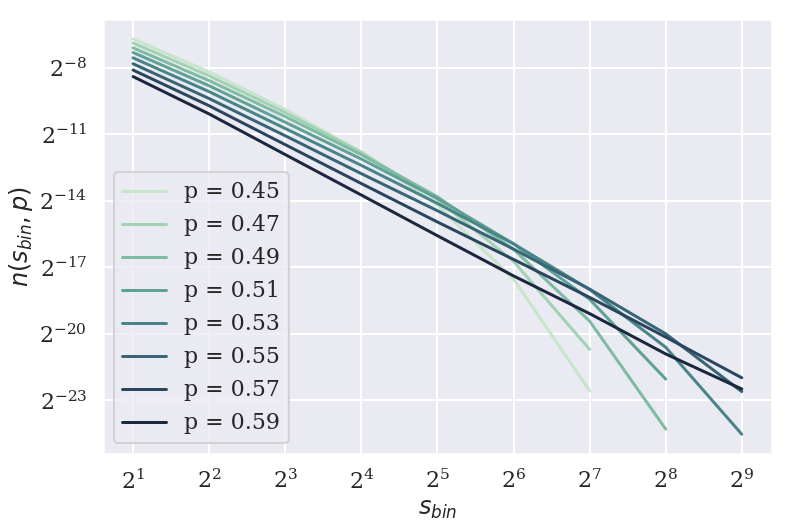

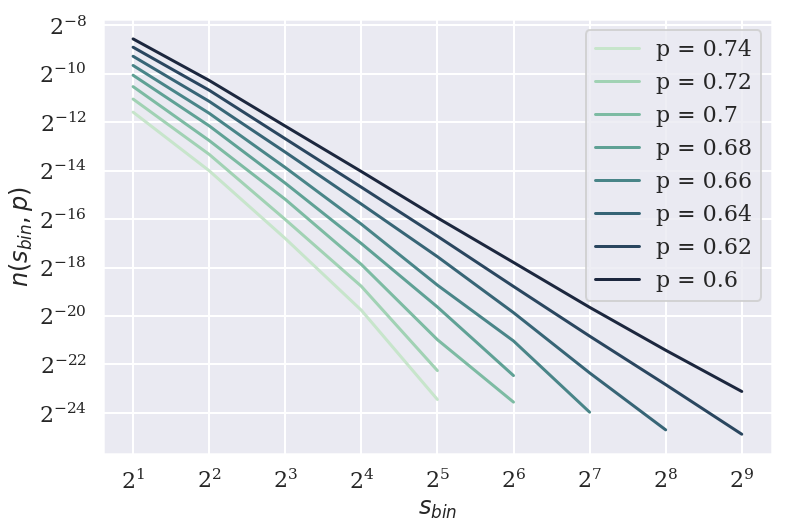

In [4]:
nbins = 10
cluster_bins = logspace(1, nbins, num=nbins, base=2)

L = 100
np = 8
probs = [0.45 + 0.02*i for i in range(np)]
simulations_cycles = 1000

nspl = cluster_number_density(probs, cluster_bins, L, simulations_cycles)

with sns.cubehelix_palette(rot=-.4, n_colors=np, gamma=1):
    for i in range(np):
        plot(cluster_bins[:-1][nspl[i, :] > 2**(-25)], nspl[i, :][nspl[i, :] > 2**(-25)], label="p = {}".format(probs[i]))
        legend()
    xlabel(r"$s_{bin}$")
    ylabel(r"$n(s_{bin}, p)$")
    gca().set_xscale("log", basex=2)
    gca().set_yscale("log", basey=2)
show()

probs = [0.74 - 0.02*i for i in range(np)]
nspl = cluster_number_density(probs, cluster_bins, L, simulations_cycles)

with sns.cubehelix_palette(rot=-.4, n_colors=np, gamma=1):
    for i in range(np):
        plot(cluster_bins[:-1][nspl[i, :] > 2**(-25)], nspl[i, :][nspl[i, :] > 2**(-25)], label="p = {}".format(probs[i]))        
    legend()
    xlabel(r"$s_{bin}$")
    ylabel(r"$n(s_{bin}, p)$")
    gca().set_xscale("log", basex=2)
    gca().set_yscale("log", basey=2)
show()

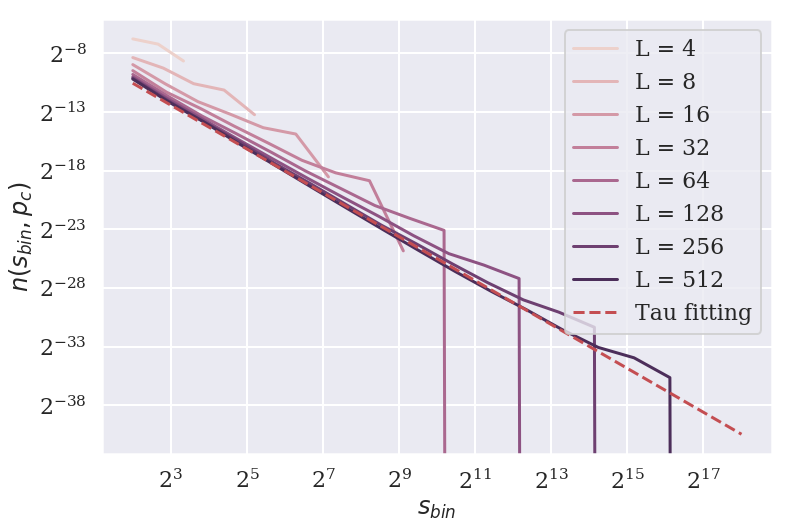

In [5]:
from scipy.stats import linregress
simulations_cycles = 1000

Ls = [2**i for i in range(2, 10)]
pc = [0.59275]

with sns.cubehelix_palette(n_colors=np+1, gamma=1):
    for L in Ls:
        cluster_bins = logspace(2, log2(L*L), num=log2(L*L), base=2)
        nspl = cluster_number_density(pc, cluster_bins, L, simulations_cycles)
        plot(cluster_bins[:-1], nspl[0, :], label="L = {}".format(L))

tau_minus, log_C, _, _, _ =  linregress(log2(cluster_bins[1:-4]), log2(nspl[0, 1:-3]))
tau = 0 - tau_minus
C = 2**log_C

plot(cluster_bins[:], C*cluster_bins[:]**(-tau), "r--", label="Tau fitting")
    
legend()
xlabel(r"$s_{bin}$")
ylabel(r"$n(s_{bin}, p_c)$")
gca().set_xscale("log", basex=2)
gca().set_yscale("log", basey=2)

show()

In [6]:
print("Tau is estimated to be {}".format(tau))

Tau is estimated to be 1.86951013088


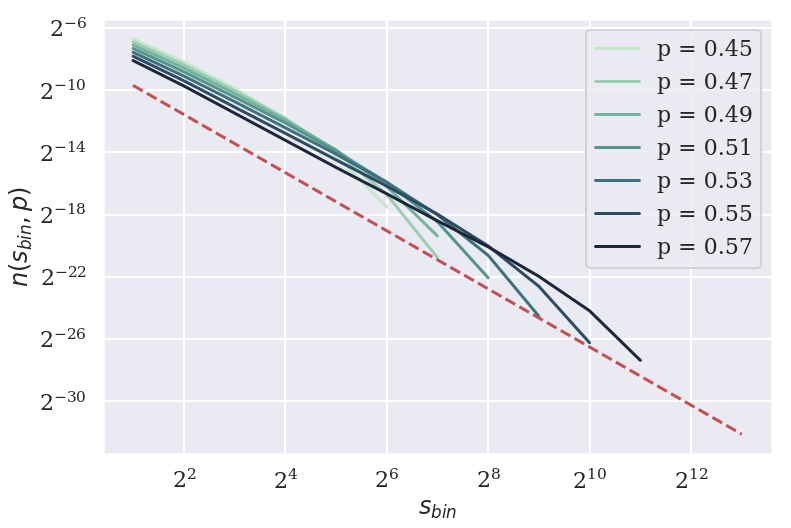

In [7]:
nbins = 14
cluster_bins = logspace(1, nbins, num=nbins, base=2)

L = 100
np = 7
probs = [0.45 + 0.02*i for i in range(np)]
simulations_cycles = 1000

nspl = cluster_number_density(probs, cluster_bins, L, simulations_cycles)
linecutter = 0.5*C*cluster_bins[:-1]**(-tau)

with sns.cubehelix_palette(rot=-.4, n_colors=np, gamma=1):
    for i in range(np):
        plot(cluster_bins[:-1][nspl[i, :] > linecutter], nspl[i, :][nspl[i, :] > linecutter], 
             label="p = {}".format(probs[i]))        
    xlabel(r"$s_{bin}$")
    ylabel(r"$n(s_{bin}, p)$")
    gca().set_xscale("log", basex=2)
    gca().set_yscale("log", basey=2)


plot(cluster_bins[:-1], linecutter, "r--")
legend()
show()

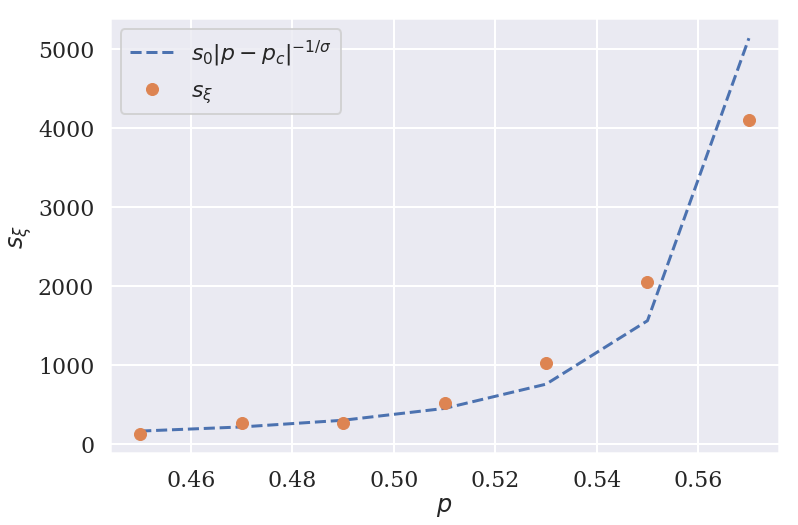

Estimated sigma = 0.528537293102


In [62]:
inters = zeros(nspl.shape[0]) # intersection at s_xi
for i in range(nspl.shape[0]):
    tmp = nspl[i, :] - 0.5*C*cluster_bins[:-1]**(-tau)
    inters[i] = cluster_bins[argmin(tmp > 0)]

diff_p = abs(array(probs) - pc[0])
slope, _, _, _, _ = linregress(log(diff_p), log(inters))
sigma = -1.0 / slope

ylabel(r"$s_\xi$")
xlabel(r"$p$")
plot(probs, cluster_bins[1]*diff_p**(-1.0 / sigma), '--', label=r"$s_0|p - p_c|^{-1/\sigma}$")
plot(probs, inters, 'o', label=r"$s_{\xi}$")

legend()
show()

print("Estimated sigma = {}".format(sigma))